In [1]:
%load_ext autoreload
%autoreload 2

# Growth rate estimation

In [2]:
import numpy
import pandas
import pathlib
import matplotlib.cm
from matplotlib import pyplot

import bletl
import bletl_analysis

### Parse the raw data file

In [3]:
filepath = pathlib.Path(r'..\bletl\tests\data\BL1\NT_1200rpm_30C_DO-GFP75-pH-BS10_12min_20171221_121339.csv')
bldata = bletl.parse(filepath, lot_number=1515, temp=30)

Now we can retrieve a new FilterTimeSeries containing the specific growth rate over time. Calculation time higly depends on dataset size and computation power, but can take around 20 -- 100 min for a whole plate. Thus, we calculate only for selected wells here. We update our BLdata-object with the new FilterTimeSeries.

In [4]:
wells = [f'{r}01' for r in 'ABCDEF']
bldata.update({
    'mue': bletl_analysis.get_mue(bldata['BS10'], wells=wells)
})

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.0s remaining:    2.2s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.5s finished


Getting a visual on the data

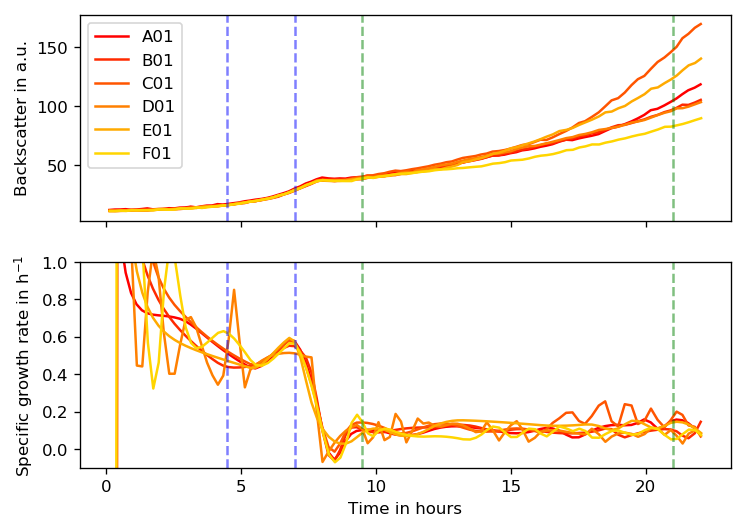

In [5]:
phase1 = numpy.array([4.5, 7])
phase2 = numpy.array([9.5, 21])

fig, ax = pyplot.subplots(2, figsize=(7,5), dpi=120, sharex=True)
for w, well in enumerate(wells):
    color = matplotlib.cm.autumn(w / len(wells))
    ax[0].plot(*bldata['BS10'].get_timeseries(well), label=well, color=color)
    ax[1].plot(*bldata['mue'].get_timeseries(well), label=well, linestyle='-', color=color)

for a in fig.axes:
    [a.axvline(t, color='blue', alpha=0.5, ls='dashed') for t in phase1]
    [a.axvline(t, color='green', alpha=0.5, ls='dashed') for t in phase2]
    
ax[1].set_ylim([-0.1, 1])    
ax[1].set_xlabel('Time in hours')
ax[0].set_ylabel('Backscatter in a.u.')
ax[1].set_ylabel('Specific growth rate in h$^{-1}$')
ax[0].legend()
pyplot.show()

Two growth phases are visible (blue and green). We calculate median specific growth rate, 25 and 75 percentiles.

In [6]:
mue_stats = pandas.DataFrame(
    index=wells, 
    columns=pandas.MultiIndex.from_product([['phase1', 'phase2'], ['median', '25p', '75p']]),
    dtype=float,
)

for well in wells:
    t, mue = bldata['mue'].get_timeseries(well)
    for pretty, percentile in zip(['median', '25p', '75p'], [50, 25, 75]):
        mue_stats.loc[well, ('phase1', pretty)] = numpy.percentile(mue[(t>phase1[0]) & (t<phase1[1])], percentile)
        mue_stats.loc[well, ('phase2', pretty)] = numpy.percentile(mue[(t>phase2[0]) & (t<phase2[1])], percentile)

mue_stats.round(decimals=2)

phase1             phase2            
    median   25p   75p median   25p   75p
A01   0.49  0.45  0.53   0.10  0.09  0.12
B01   0.47  0.44  0.52   0.10  0.09  0.11
C01   0.50  0.47  0.53   0.12  0.10  0.15
D01   0.51  0.47  0.51   0.10  0.08  0.12
E01   0.47  0.45  0.54   0.13  0.11  0.14
F01   0.51  0.47  0.56   0.08  0.07  0.10